In [1]:
from scipy import io, ndimage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

# Simulate data

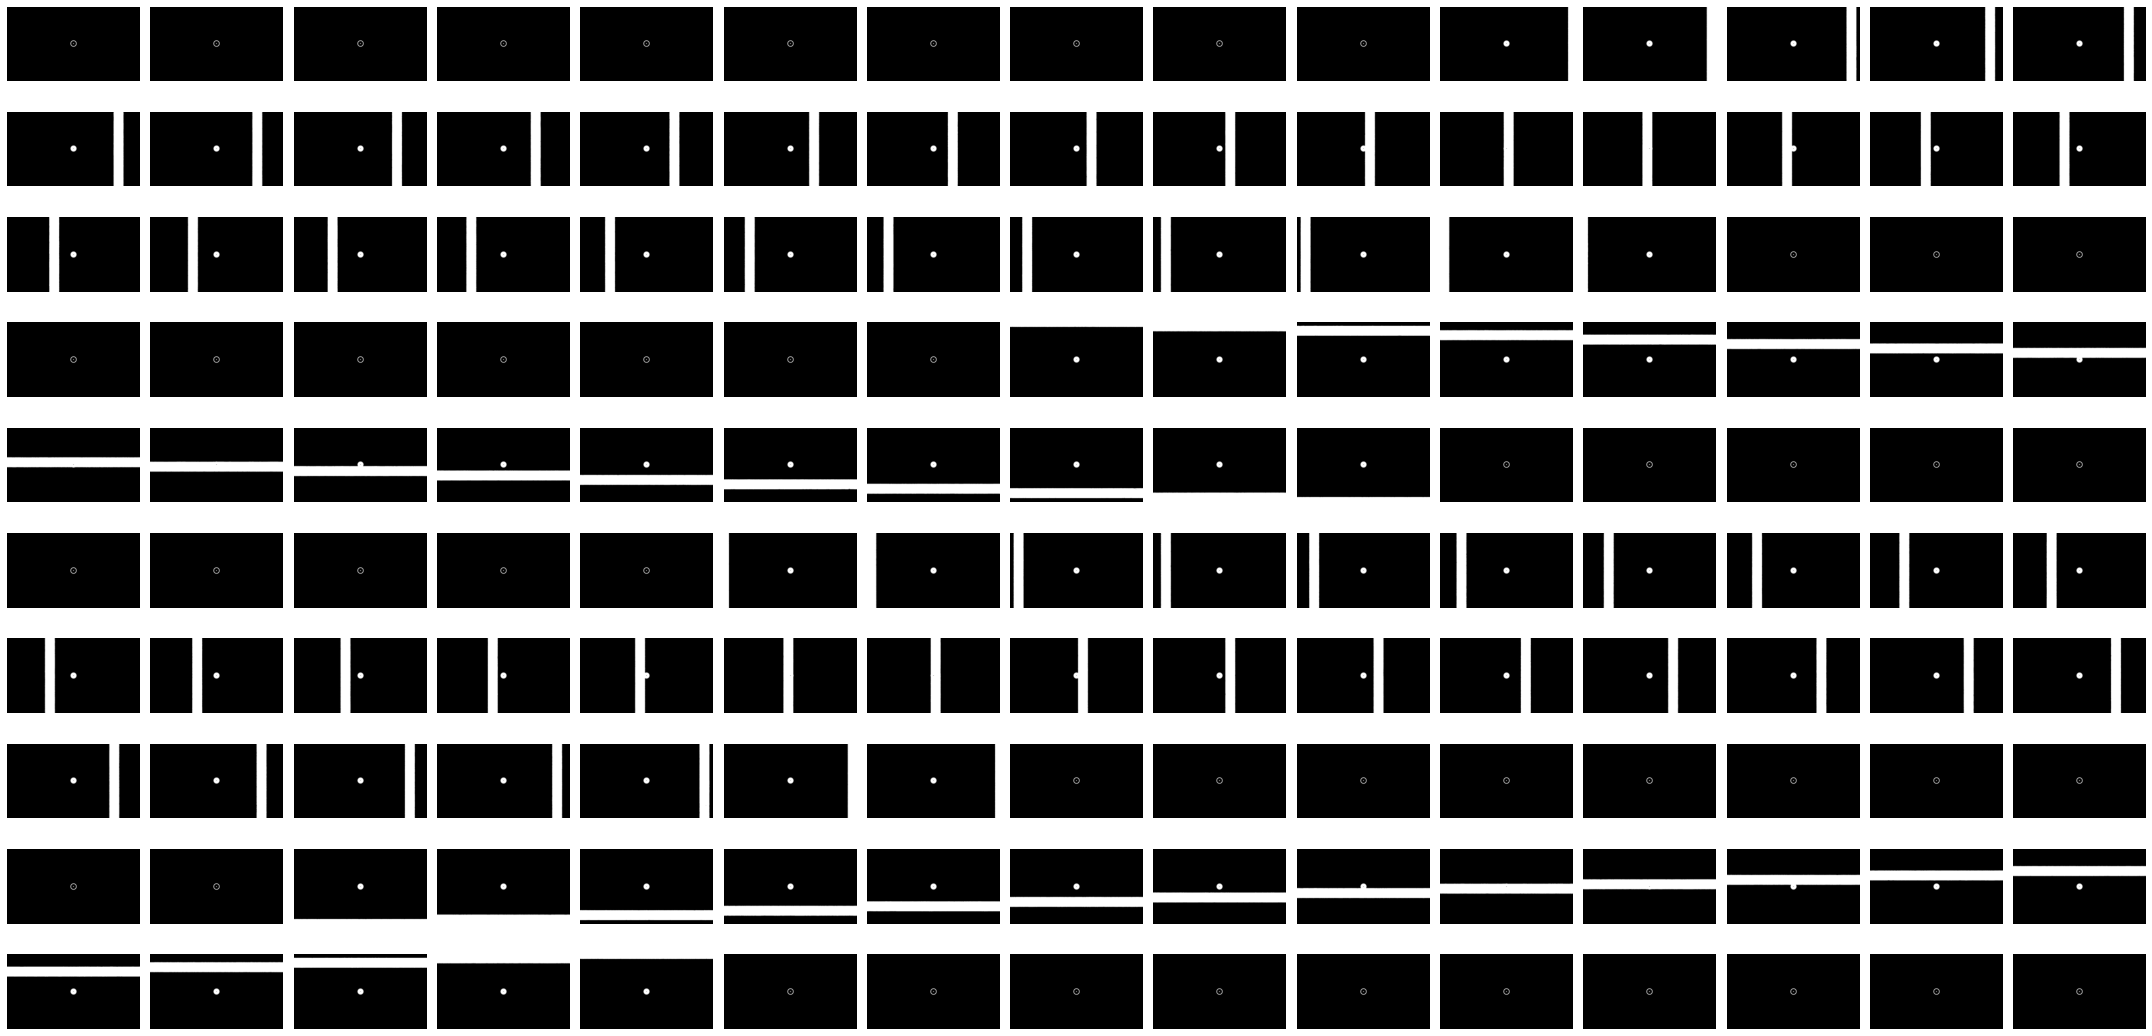

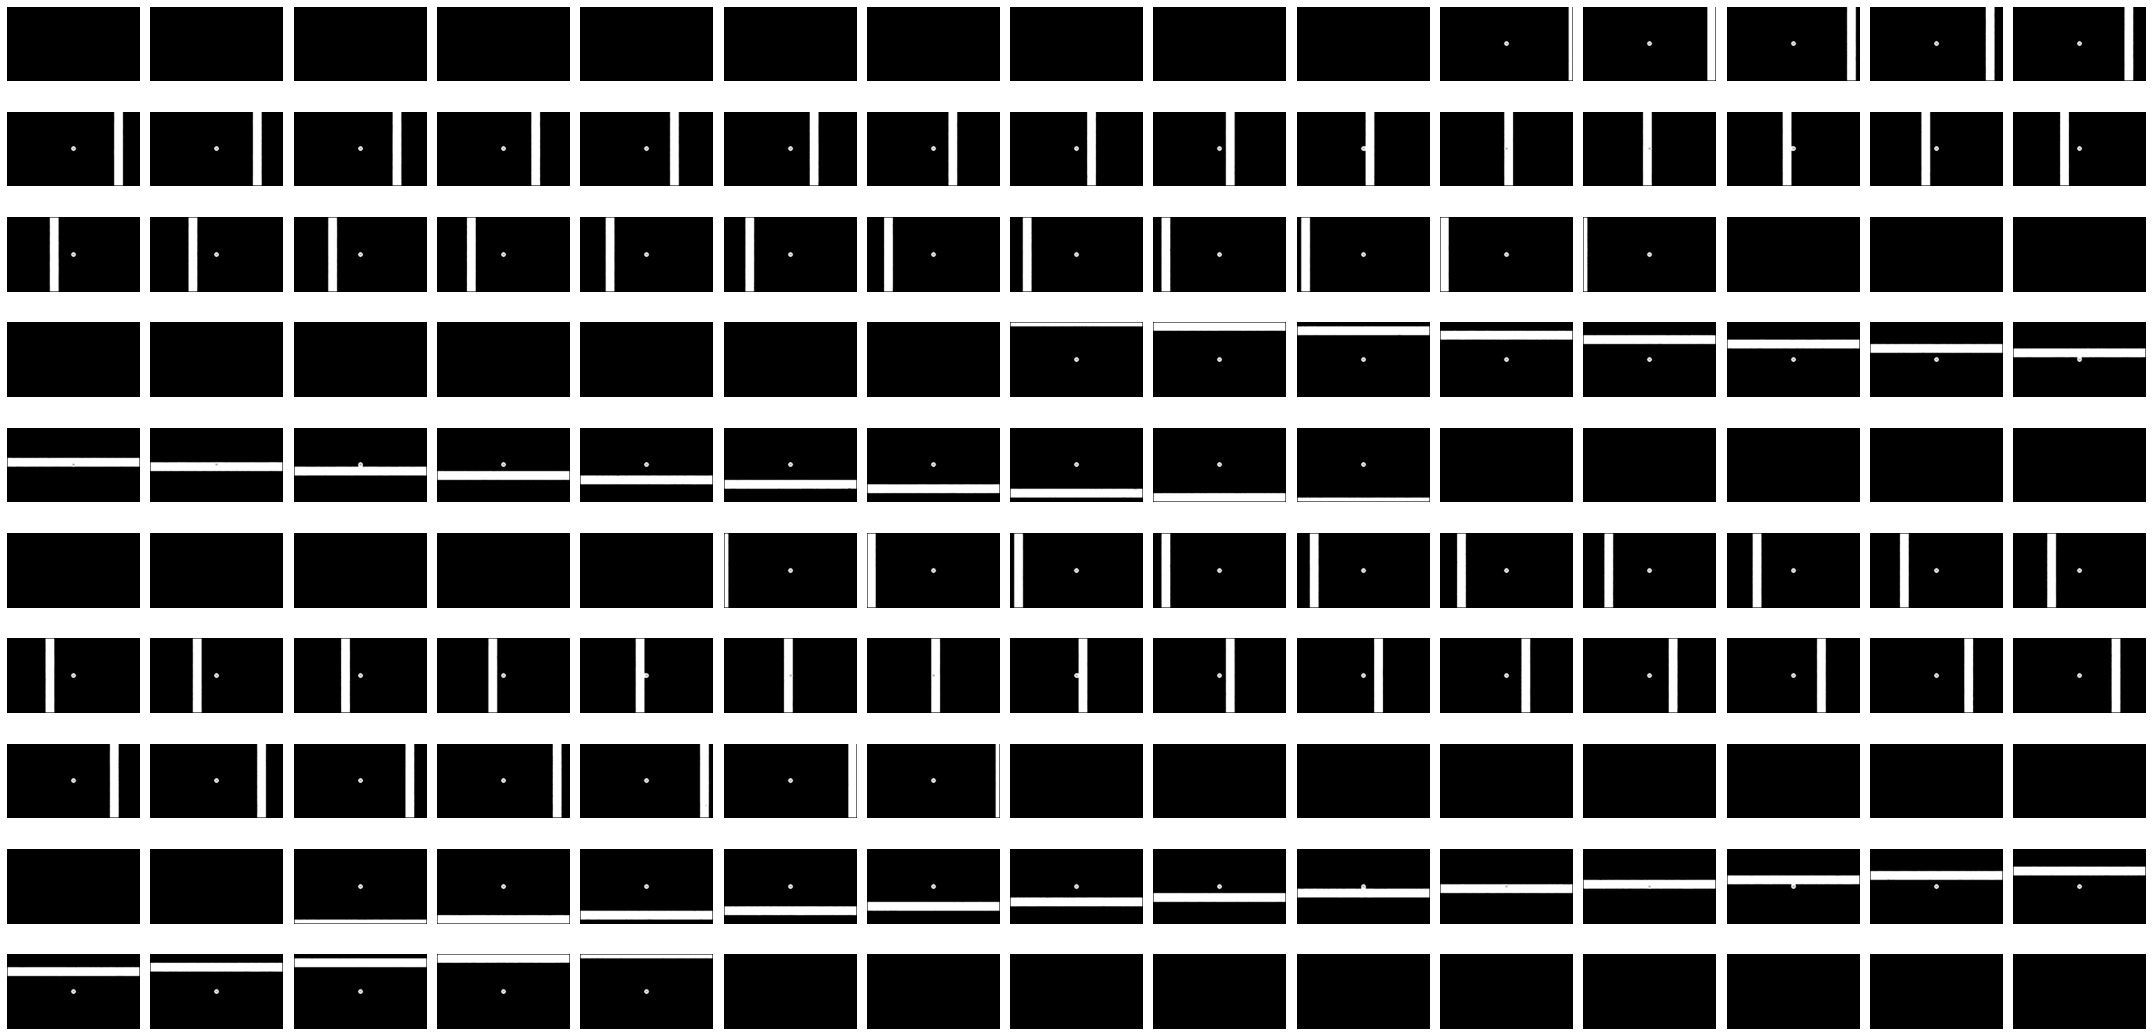

In [2]:
dm = io.loadmat('GazeCenterFS_vd.mat')['stim']

# braincoder convention is time by x by y
paradigm = np.rollaxis(dm, 2, 0)

f = plt.figure(figsize=(30, 15))
for i in range(paradigm.shape[0]):
    plt.subplot(10, 15, i + 1)
    plt.imshow(paradigm[i, :, :].T, cmap='gray')
    plt.axis('off')
plt.tight_layout()

paradigm = np.array([ndimage.minimum_filter(p, size=3, mode='constant') for p in paradigm])
f = plt.figure(figsize=(30, 15))
for i in range(paradigm.shape[0]):
    plt.subplot(10, 15, i + 1)
    plt.imshow(paradigm[i, :, :].T, cmap='gray')
    plt.axis('off')
plt.tight_layout()


In [3]:
aspect_ratio = paradigm.shape[2] / paradigm.shape[1]

x, y = np.meshgrid(np.linspace(-.75, .75, 10), np.linspace(-aspect_ratio *.75, aspect_ratio *.75, 10))

In [4]:
parameters = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.0001,
               'baseline':0.0}).astype(np.float32)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

In [5]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel

In [6]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.3))

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-08-08 21:15:50.605737: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-08 21:15:50.605854: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2022-08-08 21:15:50.757906: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-08 21:15:50.758030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


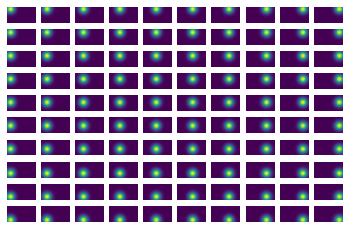

In [7]:
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(model.get_rf()[i].reshape((240, 135)).T)
    plt.axis("off")

## Predictions (no noise)

(150, 100)


2022-08-08 21:15:52.628508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:xlabel='time'>

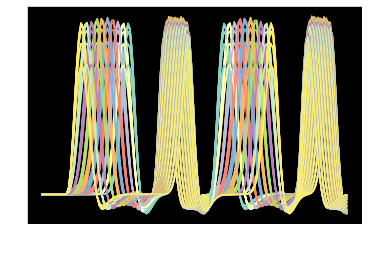

In [8]:
pred = model.predict()
pred.plot(legend=False)

## Noisy predictions

(1, 150, 100)


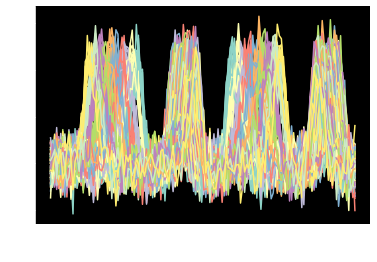

In [9]:
data = model.simulate(noise=2.5)
data.plot(legend=False)
sns.despine()

# Estimate parameters

In [10]:
from braincoder.optimize import ParameterFitter

In [11]:
fitter = ParameterFitter(model, data, paradigm)

In [12]:
grid_pars = fitter.fit_grid(x=np.linspace(-1, 1, 20), 
                            y=np.linspace(-aspect_ratio, aspect_ratio, 20),
                            sd=np.linspace(0.01, 1., 10),
                            baseline=[0.0],
                            amplitude=[1.0],
                            use_correlation_cost=True)

Working with chunk size of 44444
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


In [13]:
grid_pars

,x,y,sd,baseline,amplitude
0,-0.789474,-0.444079,0.23,0.0,1.0
1,-0.578947,-0.444079,0.23,0.0,1.0
2,-0.368421,-0.444079,0.23,0.0,1.0
3,-0.263158,-0.444079,0.23,0.0,1.0
4,-0.052632,-0.444079,0.23,0.0,1.0
...,...,...,...,...,...
95,0.052632,0.384868,0.23,0.0,1.0
96,0.263158,0.503289,0.23,0.0,1.0
97,0.473684,0.444079,0.23,0.0,1.0
98,0.578947,0.444079,0.23,0.0,1.0


In [14]:
ols_pars = fitter.refine_baseline_and_amplitude(grid_pars)

(150, 100)
Original mean r2: -1663828.125
(150, 100)
100.00% of time lines improved
(150, 100)
New mean r2 after OLS: 0.8552360534667969
(150, 100)
Original mean r2: 0.8552360534667969
(150, 100)
4.00% of time lines improved
(150, 100)
New mean r2 after OLS: 0.8552360534667969


In [15]:
ols_pars

,x,y,sd,baseline,amplitude
0,-0.789474,-0.444079,0.23,1.232977,0.000872
1,-0.578947,-0.444079,0.23,-2.812796,0.000910
2,-0.368421,-0.444079,0.23,0.353771,0.000860
3,-0.263158,-0.444079,0.23,-3.956482,0.000913
4,-0.052632,-0.444079,0.23,-2.909285,0.000858
...,...,...,...,...,...
95,0.052632,0.384868,0.23,-2.836490,0.000780
96,0.263158,0.503289,0.23,1.224259,0.000969
97,0.473684,0.444079,0.23,3.621137,0.000834
98,0.578947,0.444079,0.23,1.123014,0.000868


In [16]:
refined_pars = fitter.fit(init_pars=ols_pars, learning_rate=0.001)

2022-08-08 11:18:48.505994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 100


  0%|          | 0/1000 [00:00<?, ?it/s]2022-08-08 11:18:48.636089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 11:18:48.926350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 11:18:49.136658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 11:18:49.256354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Current R2: 0.86546/Best R2: 0.86546: 100%|██████████| 1000/1000 [00:20<00:00, 48.00it/s]


(150, 100)


In [17]:
refined_pars

parameter,x,y,sd,baseline,amplitude
0,-0.746379,-0.406180,0.193884,1.342348,0.000957
1,-0.580532,-0.443852,0.222549,-2.717320,0.000947
2,-0.416928,-0.435169,0.211882,0.538832,0.000951
3,-0.236517,-0.408307,0.211370,-3.889379,0.000964
4,-0.072284,-0.424847,0.221127,-2.869633,0.000875
...,...,...,...,...,...
95,0.066728,0.394610,0.215331,-2.613247,0.000865
96,0.249029,0.447095,0.204365,1.337277,0.001012
97,0.431202,0.445516,0.216234,3.726000,0.000908
98,0.613394,0.421308,0.208027,1.298573,0.000956


In [18]:
r2 = fitter.get_rsq(refined_pars)
r2

(150, 100)


0     0.784633
1     0.851807
2     0.849082
3     0.848369
4     0.844047
        ...   
95    0.844855
96    0.847950
97    0.829078
98    0.847466
99    0.831521
Length: 100, dtype: float32

# Mexican hat model

In [19]:
from braincoder.models import DifferenceOfGaussiansPRF2DWithHRF

In [20]:
parameters_dog = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.001,
               'baseline':0.0,
               'srf_amplitude':.6, 
               'srf_factor':2.}).astype(np.float32)

In [21]:
model_dog = DifferenceOfGaussiansPRF2DWithHRF(grid_coordinates, paradigm, parameters=parameters_dog,
                                             hrf_model=SPMHRFModel(tr=1.8))

In [22]:
pred_dog = model_dog.predict()

(150, 100)


2022-08-08 11:19:09.823874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:xlabel='time'>

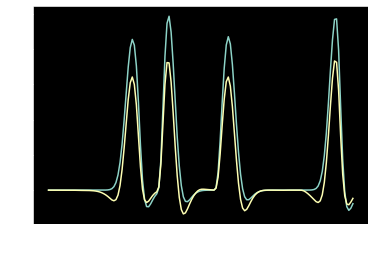

In [23]:
pred[0].plot()
pred_dog[0].plot()

In [24]:
data_dog = model.simulate(noise=35)
# data_dog.plot(legend=False)
# sns.despine()

(1, 150, 100)


In [25]:
fitter = ParameterFitter(model_dog, data_dog, paradigm)

In [26]:
est_pars_dog = refined_pars.copy()
est_pars_dog['srf_amplitude'] = 0.1
est_pars_dog['srf_factor'] = 2.

In [27]:
est_pars_dog = fitter.fit(init_pars=est_pars_dog, learning_rate=0.0001)

2022-08-08 11:19:10.117457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 100


  0%|          | 0/1000 [00:00<?, ?it/s]2022-08-08 11:19:10.284917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 11:19:10.798873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 11:19:11.034046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 11:19:11.215397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Current R2: 0.85962/Best R2: 0.85962: 100%|██████████| 1000/1000 [00:24<00:00, 40.19it/s]


(150, 100)


In [28]:
est_pred = model.predict(parameters=est_pars_dog)

2022-08-08 11:19:35.186048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(150, 100)


<AxesSubplot:xlabel='time'>

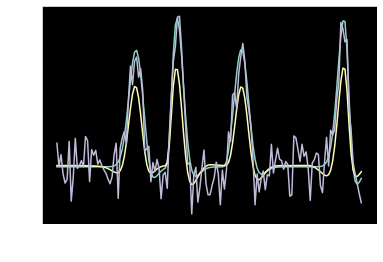

In [29]:
est_pred[1].plot()
pred_dog[1].plot()
data_dog[1].plot()

In [30]:
est_pars_dog

parameter,x,y,sd,baseline,amplitude,srf_amplitude,srf_factor
0,-0.738052,-0.406346,0.204568,1.432785,0.000946,0.093131,1.945193
1,-0.594847,-0.419829,0.209971,-2.806392,0.001054,0.108194,2.042153
2,-0.419776,-0.396432,0.203846,0.636737,0.001004,0.092918,1.943727
3,-0.253715,-0.375387,0.201933,-3.979643,0.001004,0.097477,1.947109
4,-0.092195,-0.413741,0.211847,-2.768359,0.000879,0.092896,1.944953
...,...,...,...,...,...,...,...
95,0.067285,0.417469,0.206841,-2.515976,0.000968,0.096566,1.957083
96,0.218646,0.398174,0.202978,1.353487,0.000942,0.096190,1.952922
97,0.421760,0.434599,0.204535,3.637225,0.001013,0.107241,1.999252
98,0.566279,0.439380,0.216384,1.388644,0.001029,0.098330,2.044805


In [31]:
parameters_dog

,x,y,sd,amplitude,baseline,srf_amplitude,srf_factor
0,-0.750000,-0.421875,0.2,0.001,0.0,0.6,2.0
1,-0.583333,-0.421875,0.2,0.001,0.0,0.6,2.0
2,-0.416667,-0.421875,0.2,0.001,0.0,0.6,2.0
3,-0.250000,-0.421875,0.2,0.001,0.0,0.6,2.0
4,-0.083333,-0.421875,0.2,0.001,0.0,0.6,2.0
...,...,...,...,...,...,...,...
95,0.083333,0.421875,0.2,0.001,0.0,0.6,2.0
96,0.250000,0.421875,0.2,0.001,0.0,0.6,2.0
97,0.416667,0.421875,0.2,0.001,0.0,0.6,2.0
98,0.583333,0.421875,0.2,0.001,0.0,0.6,2.0


In [32]:
r2 = fitter.get_rsq()

(150, 100)


In [33]:
r2

0     0.808812
1     0.865206
2     0.808962
3     0.854838
4     0.806391
        ...   
95    0.821122
96    0.828812
97    0.818319
98    0.852897
99    0.817367
Length: 100, dtype: float32

# CSS model

In [10]:
from braincoder.models import CSSGaussianPRF2DWithHRF

parameters_css = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'baseline': 0.0,
               'amplitude': 0.5,
               'exponent':.3}).astype(np.float32)

In [11]:
model_css = CSSGaussianPRF2DWithHRF(grid_coordinates, paradigm, parameters=parameters_css,
                                             hrf_model=SPMHRFModel(tr=1.3))

In [12]:
pred_css = model_css.predict()

(150, 100)


2022-08-08 21:16:00.876600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:xlabel='time'>

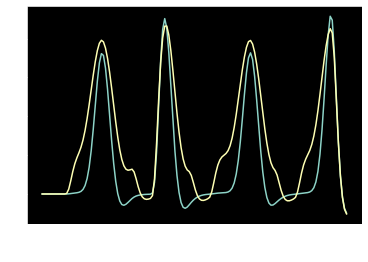

In [13]:
pred[5].plot()
pred_css[5].plot()

# DN Model

In [42]:
from braincoder.models import DivNormGaussianPRF2DWithHRF

parameters_dn = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd_activation':1.0,
               'constant_activation':1.0,
               'amplitude_activation':10,
               'sd_normalization':2.0,
               'constant_normalization': 1,
               'amplitude_normalization': 3}).astype(np.float32)

In [43]:
model_dn = DivNormGaussianPRF2DWithHRF(grid_coordinates, 
                                       paradigm, 
                                       parameters=parameters_dn,
                                       hrf_model=SPMHRFModel(tr=1.3))

In [44]:
pred_dn = model_dn.predict()

(150, 100)


2022-08-08 21:17:29.679975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:xlabel='time'>

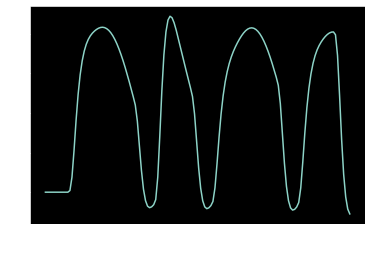

In [45]:
# pred[5].plot()
pred_dn[5].plot()